# Task 3: Evaluierung 

In folgendem Abschnitt werden unsere Recommender hergestellt und getestet. Alle erstellten Funktionen und verwendete Bibliotheken befinden sich in unerer Helper-Datei 'p.py'. Dies erleichtert uns den Überblick über das gesammte Notebook.

In [1]:
# import functions and libraries from helper-file
from p import *

## Daten einlesen & bereinigen
Wir lesen hier die Dateien ein und führen sie zusammen anhand der tmdbId --> So bekommen wir die entsprechende movieIds

In [2]:
# read data
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


Hier extrahieren wir die relevanten Daten aus den angegebenen Spalten, weil sie dort verschachtelt sind.

In [3]:
# extract data from dictionaries and list, separate key values by '|'
## extract function
def extract_values(data):
    return data.apply(lambda x: "|".join([i["name"] for i in eval(x)]))

## actual extraction
df_movies["genres"] = extract_values(df_movies["genres"])
df_movies["spoken_languages"] = extract_values(df_movies["spoken_languages"])
df_movies["production_companies"] = extract_values(df_movies["production_companies"])
df_movies["production_countries"] = extract_values(df_movies["production_countries"])

Hier haben wir die Spalten definiert und geordnet, die wir benötigen (alle anderen wurden automatisch entfernt)

In [4]:
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "release_date", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
]
# reorder columns
df_movies = df_movies[col_order]

Wir entfernen Filme mit einer Laufzeit von unter 30 Minuten und über 300 Minuten, da wir für unseren Recommender keine Kurz - oder Langfilme beachten wollen.

In [5]:
# drop rows with runtime under 30 --> remove short films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] < 30].index)

# drop rows with runtime over 300 --> remove long films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] > 300].index)

Hier wurden die Daten weiter bereinigt; MovieId Duplikate und leere Filmbeschreibungen entfernt 

In [6]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df_movies = df_movies.drop_duplicates(subset = df_movies.columns.difference(["movieId"]))

# remove all overviews that are nan
df_movies = df_movies.dropna(subset=["overview"])

Jetzt exportieren wir den bereinigten Dataframe, damit wir die enthaltenen Daten später bei der explorativen Datenanalyse untersuchen können.

In [7]:
# export df_movies to csv 
df_movies.to_csv('ml-25m/movies_clean.csv', index = False)

### Movie Ratings
Hier lesen wir die Filmbewertungen ein.

So können wir dann Bewertungen plausibilisieren --> falls diese Daten unmöglich sind (zb eine Bewertung wurde vor der Veröffentlichung vom Film erstellt), werden sie gelöscht.

In [9]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

Wir haben Filme von der TMDB API abgefragt und gespeichert (df_movies) und wir wollen jetzt nur die Bewertungen behalten, deren Filme dich in df_movies befinden. Darum schauen wir, ob die movieIds übereinstimmen, falls ja dann werden diese Bewertungen beibehalten. Alle andere Bewertungen werden automatisch gelöscht, da sie irrelevant sind.

In [10]:
# only keep movie ratings where the movieId is in df_movies
df_ratings = df_ratings[df_ratings["movieId"].isin(list(df_movies["movieId"]))]

Danach konvertieren wir die "timestamp" Spalte zu einem "datetime" Objekt und speichern das in einer neuen Spalte namens "date". Die Spalte "timestamp" wird anschliessend gelöscht.

In [11]:
# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop the old timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

Jetzt werden beide Dataframes zusammengeführt.

In [12]:
# merge movies and ratings on movieId
df_movies_ratings = pd.merge(df_ratings, df_movies, on = "movieId")

Wir müssen jetzt die Daten plausibilisieren.

Wir setzen dies um, indem wir Bewertungen löschen, welche vor dem Erscheinungsdatum abgegeben wurden.

In [13]:
# drop rows where the ratings were submitted before the movie released
df_movies_ratings = df_movies_ratings[df_movies_ratings["date"] > df_movies_ratings["release_date"]]

# drop columns because they are useless now
df_movies_ratings.drop(["date", "release_date"], axis = 1, inplace = True)

Hier ist ein weiteres Beispiel von Daten zu plausibilisieren; Wir schauen, ob es Users gibt, welche den gleichen Film mehrmals bewertet haben.

In [14]:
df_movies_ratings[df_movies_ratings.duplicated(subset = ["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,production_countries


Export vom Dataframe für seperates Explorative Datenanalyse Python Notebook.

In [15]:
df_movies_ratings.to_csv('ml-25m/df_movies_ratings.csv', index=False)

## NLP Implementierung

Bei unserer Challenge haben wir uns für folgende drei nlp-Algortihmen entschieden:

· TF-IDF (Termhäufigkeit - Inverse Dokumentenhäufigkeit) ist ein numerisches Mass, das verwendet wird, um zu reflektieren, wie wichtig ein Wort für ein Dokument in einer Sammlung oder einem Korpus ist. Die Wichtigkeit steigt proportional zur Anzahl der Zeiten, die das Wort im Dokument erscheint, wird jedoch durch die Häufigkeit des Wortes im Korpus ausgeglichen. Dies hilft, die Tatsache auszugleichen, dass einige Wörter im Allgemeinen häufiger vorkommen.

· Die Latente Semantische Analyse (LSA) ist eine Technik, die verwendet wird, um Beziehungen zwischen einem Satz von Dokumenten und den von ihnen enthaltenen Begriffen zu analysieren, indem sie eine Menge von Konzepten erstellt, die mit den Dokumenten und Begriffen verbunden sind. LSA repräsentiert Dokumente und Begriffe in einem niedrigdimensionalen Raum und identifiziert Beziehungen zwischen ihnen aufgrund der Nähe der Dokumente und Begriffe in diesem Raum.

· Doc2vec ist eine Methode zur Darstellung von Dokumenten als Vektoren in einem hochdimensionalen Raum. Es ähnelt word2vec, das Wörter als Vektoren darstellt, aber doc2vec berücksichtigt den Kontext, in dem Wörter in einem Dokument erscheinen. Doc2vec kann verwendet werden, um Dokument-Embeddings zu erzeugen, die die Bedeutung eines Dokuments erfassen, die in verschiedenen Aufgaben der natürlichen Sprachverarbeitung verwendet werden können.

Anschliessend werden wir alle 3 Algorithmen miteinander vergleichen und uns für einen entscheiden für den Prototyp.

### Pre-Processing: Stemming

Bevor man mit einem NLP Algorithmus beginnt, müssen die Daten zuerst darauf vorbereitet werden (pre-processed)

Dafür haben wir in der Datei p.py eine Funktion "stemming_tokenizer" erstellt, die verschiedene Varianten eines Wortes auf ihren gemeinsamen Wortstamm zurückführt, z.B. Swimming --> Swim. 

Die Funktion löscht zudem auch noch unnötige Symbole wie Kommas und Punkte und auch "stop words". Das sind z.B. Wörter wie "the", "a" ect.

Wichtig zu wissen ist, dass die "pre-processed" Daten für alle 3 NLP Algorithmen gleich verwendet werden können.

In [16]:
# copy dataframe to avoid overwriting the original one
df_movies_nlp = df_movies.copy().reset_index(drop = True)

# loop through the chosen columns and stem the texts
for col in ["overview", "spoken_languages", "original_language", "production_companies", "production_countries"]:
    df_movies_nlp[col] = stemming_tokenizer(df_movies_nlp[col])

# create new title column with stemmed title (we don't want to stem the original title)
df_movies_nlp["new_title"] = stemming_tokenizer(df_movies_nlp["title"])

Hier sehen wir, dass wir die ausgewählten Texte auf ihren Wortstamm zurückgeführt haben.

In [17]:
df_movies_nlp.head(3)

,movieId,title,genres,overview,release_date,runtime,original_language,spoken_languages,production_companies,production_countries,new_title
0,895,Venice,Drama|Romance,atmospher come age stori featur imagin young b...,2010-06-11,110,pl,esk deutsch polski,akson studio iti cinema,poland,venic
1,2679,A Place at the Table,Documentary,use person stori power documentari illumin pli...,2012-03-22,84,en,english,,unit state america,place tabl
2,4249,Kingdom Come,Comedy|Documentary,documentari kingdom come follow first time dir...,2011-01-01,88,en,,,,kingdom come


#### Kombinationsentscheid von Spalten für den perfekten Score

Wir schreiben eine Funktion namens 'create_combinations', die in der Datei 'p.py' enthalten ist. Die Funktion fügt zufällig die angegebene Anzahl von Spalten hinzu, um systematisch herauszufinden, welche Kombination von Spalten (Daten) die höchsten Scores oder die besten Vorschläge für Filme hat.

 Folgende Attribute wollen wir für die Berechnung verwenden
- Titel
- Overview
- Original Language
- Spoken Language
- Production Companies
- Production Countries

Wir rufen die Funktion 'create_combinations' auf und sie erstellt einen Dataframe, der alle Filme mit 10 Filmvorschlägen enthält. Danach wird der Dataframe als CSV-Datei exportiert und wieder eingelesen, damit wir die Funktion nicht jedes Mal ausführen müssen, wenn wir die Ergebnisse ansehen wollen. Aus diesem Grund ist der Code im folgenden Block auskommentiert.

In [ ]:
# get recommendations for each movie based on the combinations
# df_recommendations = recommendations_per_comb(df_movies_nlp, df_movies)

# sort the recommendations by score1
# df_recommendations.sort_values(by = ["movie", "score_1"], ascending = False)

# export dataframe to csv for later
# df_recommendations.to_csv("rec.csv", index = False)

Hier lesen wir die Datei ein und sehen, dass für das Dataframe eine Dimension von 378880 x 22 hat (~ 19000 Filme * 20 Kombinationen). Also es wurden 10 ähnliche Filme pro Film pro Spaltenkombination vorgeschlagen.

In [18]:
# read the recommendations dataframe
rec = pd.read_csv("ml-25m/rec.csv", index_col = "Unnamed: 0")

# show dimension
print(rec.shape)

rec.head()

(378880, 22)


,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
0,"['new_title', 'overview', 'spoken_languages', ...",Venice,Panic Attack,0.154583,7 Things You Don't Know About Men,0.148710,Embassy,0.148499,Letters to Santa,0.139134,...,Women of Mafia 2,0.137449,Gods,0.134155,Hardkor Disko,0.130372,Breakfast in Bed,0.130297,Walpurgis Night,0.129467
1,"['new_title', 'overview', 'spoken_languages', ...",A Place at the Table,Food and Shelter,0.229952,Food Stamped,0.085962,The Anonymous People,0.084057,Mixed Doubles,0.074443,...,Food Choices,0.071564,Farmageddon,0.063199,Growing Cities,0.062772,Eating Animals,0.062322,Permanent,0.061547
2,"['new_title', 'overview', 'spoken_languages', ...",Kingdom Come,"Chronic-Con, Episode 420: A New Dope",0.069982,Kingdom Come,0.069428,Kevin Smith: Too Fat For 40,0.061588,Rats,0.052913,...,Barbie: Princess Charm School,0.047550,The Special Relationship,0.045128,"The Death of ""Superman Lives"": What Happened?",0.045053,Selma,0.042078,Wonder,0.042025
3,"['new_title', 'overview', 'spoken_languages', ...","Camille Claudel, 1915",Rodin,0.173721,Ducoboo 2: Crazy Vacation,0.124234,Oh Mercy,0.117102,Camille Rewinds,0.108202,...,Trophy Wife,0.096784,School Life,0.093823,House of Pleasures,0.091848,Eva,0.091395,My Golden Days,0.090107
4,"['new_title', 'overview', 'spoken_languages', ...",My Kingdom,White Vengeance,0.098080,The Final Master,0.080325,The Looming Storm,0.069230,Touch of the Light,0.066363,...,Buddha Mountain,0.058536,Bangkok Revenge,0.057755,The Black Devil and the White Prince,0.057549,Sword Master,0.056973,Master Z: Ip Man Legacy,0.056659


Wir erstellen hier eine neue Spalte, um die unique Kombinationen indexieren zu können.

In [19]:
## create new column based on the combination of the columns
rec["set_combination"] = rec.groupby("combination").ngroup()
rec["set_combination"].head()

0    9
1    9
2    9
3    9
4    9
Name: set_combination, dtype: int64

Von allen Kombinationen wollen wir die Score-Verteilung vom Recommended Movie 1 anschauen. Dafür erstellen wir einen Facet Plot. Die Nummern pberhalb der kleinen Plots entspricht die Kombinationsnummer (0-19). 

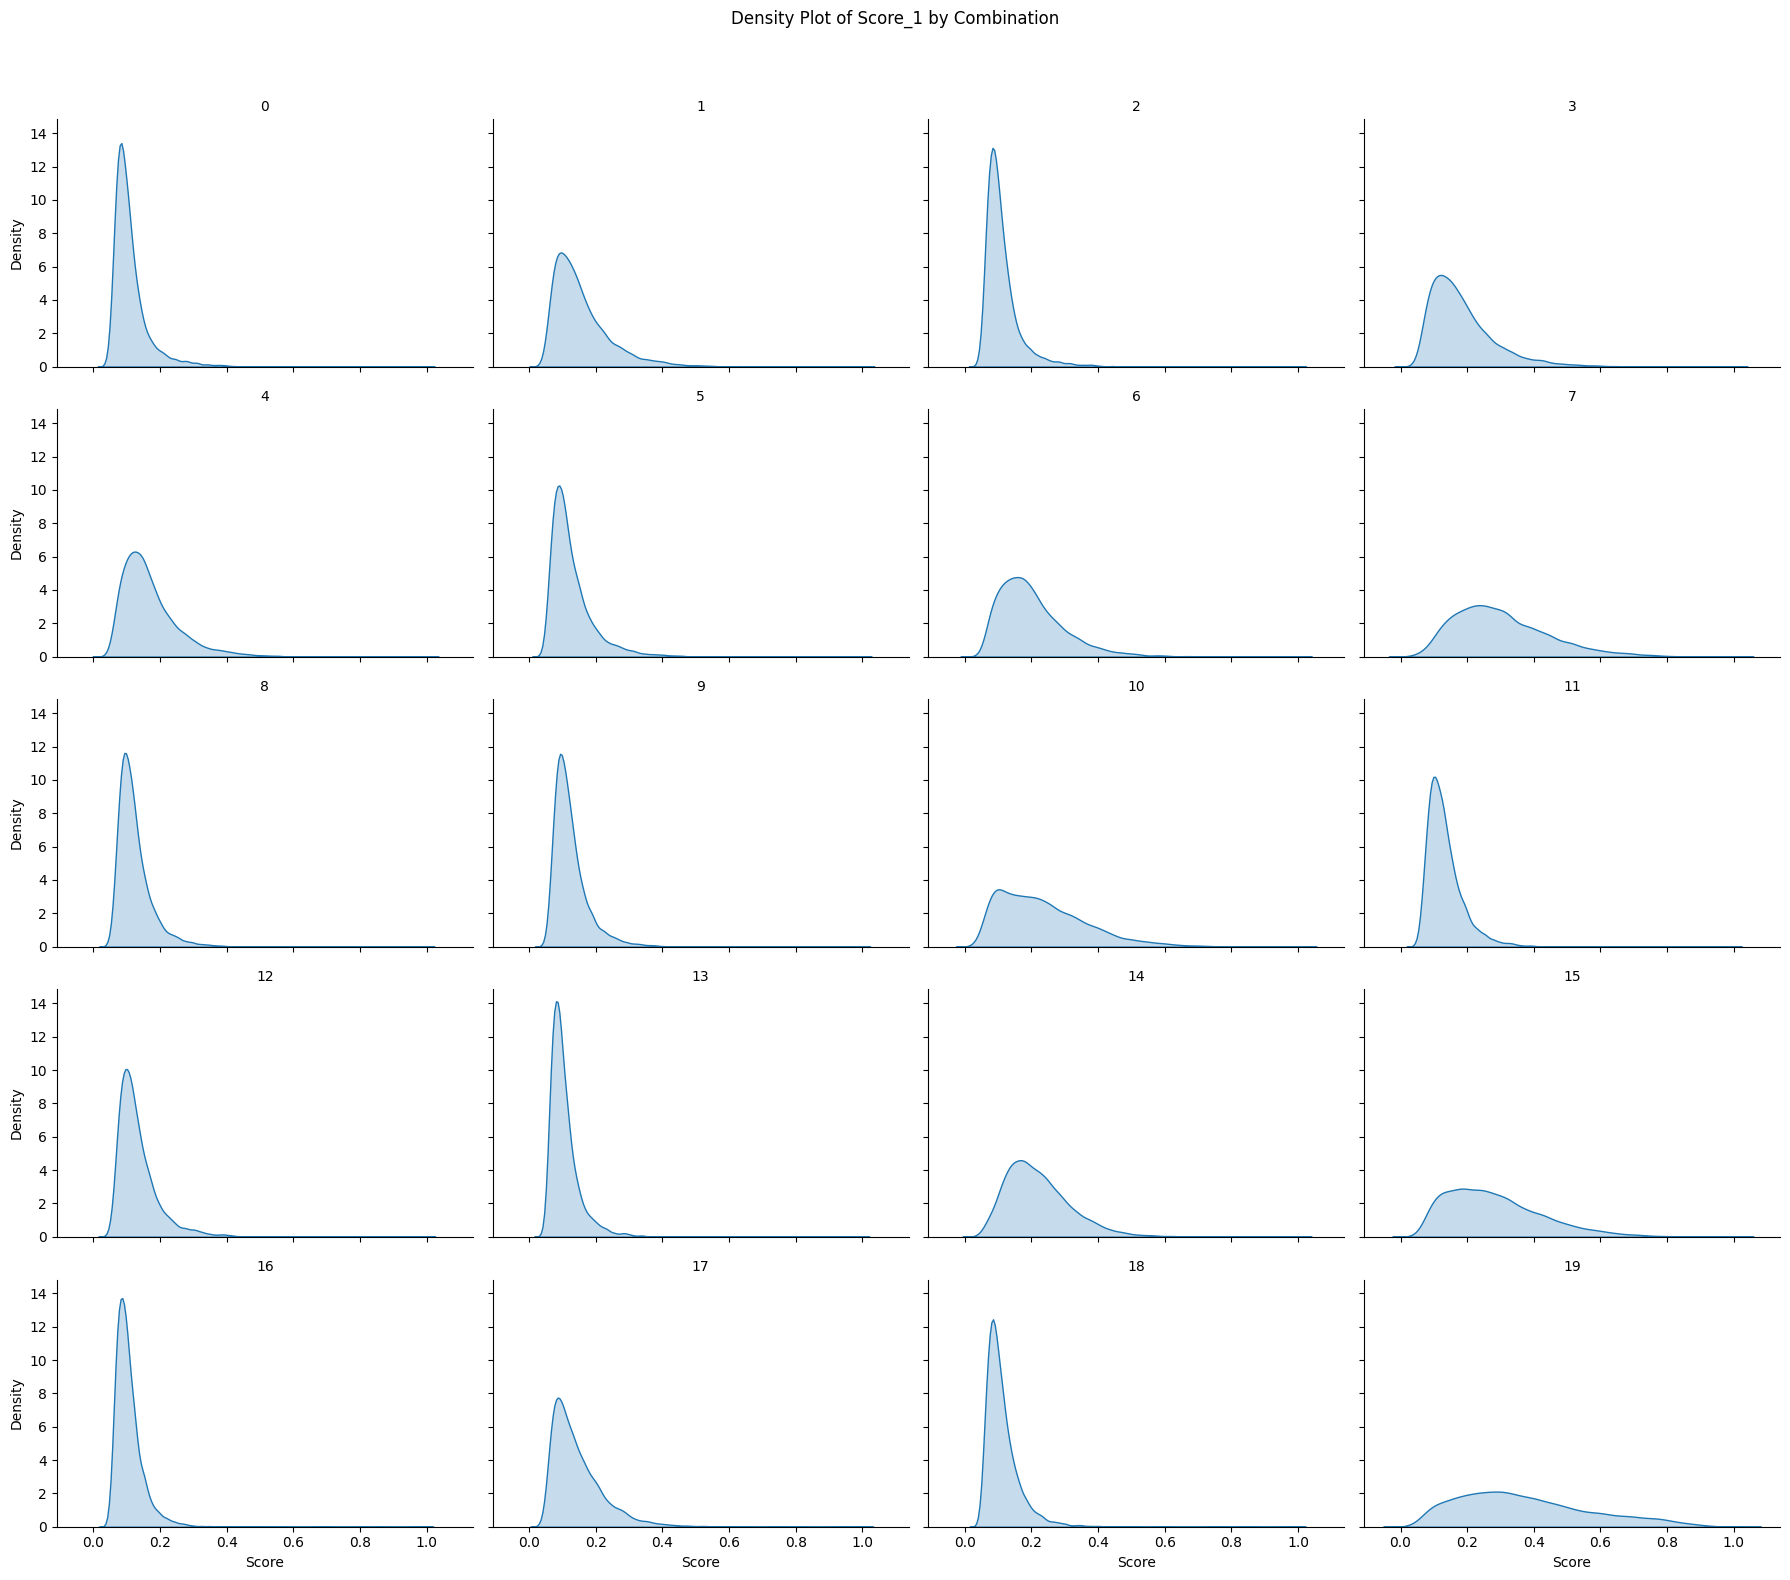

In [20]:
g = sns.FacetGrid(rec, col = "set_combination", col_wrap = 4, height = 3, aspect = 1.5)
g.map(sns.kdeplot, "score_1", fill = True)
g.set_titles(col_template = "{col_name}")
g.set_axis_labels("Score", "Density")
g.fig.suptitle("Density Plot of Score_1 by Combination", y = 1.05)
plt.show()

##### Kombination Entscheidung
Wir entscheiden uns für die Kombination 19, weil die Verteilung die höchsten Werte annimmt. 

Overview kommt 2 Mal vor, das bedeutet, dass die Wörter im Overview höcher bewertet werden (das Ziel ist es ja eher anhand des Overviews Filme vorzuschlagen)

Die Kombination sieht wie folgt aus:

In [21]:
rec[rec["set_combination"] == 19]["combination"].unique()

array(["['new_title', 'overview', 'spoken_languages', 'original_language', 'production_companies', 'production_countries', 'new_title', 'new_title', 'overview', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries']"],
      dtype=object)

In [22]:
# cols from combination 19
cols = ['new_title', 'overview', 'spoken_languages', 'original_language', 'production_companies', 'production_countries', 'new_title', 'new_title', 'overview', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries']

#### Kombination Testen

Wir testen die Kombination nun auf Filme, die wir als Gruppe sehr gut kennen: "Fast & Furious 6", "Interstellar", "Toy Story"

Dabei ist für uns erkennbar, dass die Filmvorschläge recht gut sind.

In [23]:
# we can use head(1) because the combination 19 is the first row of the dataframe
rec[rec["movie"] == "Fast & Furious 6"].sort_values(by = "score_1", ascending = False).head(1)

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
20788,"['new_title', 'overview', 'spoken_languages', ...",Fast & Furious 6,Furious 7,0.452835,The Fate of the Furious,0.442821,Fast Five,0.38839,Trainwreck,0.387489,...,0.371084,The Secret Life of Pets 2,0.301981,Survival Family,0.271846,"Rich Man, Poor Woman in New York",0.260465,Battle: Los Angeles,0.246985,19


In [24]:
rec[rec["movie"] == "Interstellar"].sort_values(by = "score_1", ascending = False).head(1)

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
21458,"['new_title', 'overview', 'spoken_languages', ...",Interstellar,Inception,0.36404,Dunkirk,0.27282,Pacific Rim,0.220115,Pacific Rim: Uprising,0.207111,...,0.182321,Krampus,0.174789,Steve Jobs,0.174336,42,0.163041,Otherhood,0.15517,19


In [25]:
rec[rec["movie"] == "Toy Story 3"].sort_values(by = "score_1", ascending = False).head(1)

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
19039,"['new_title', 'overview', 'spoken_languages', ...",Toy Story 3,Incredibles 2,0.774336,Toy Story 4,0.771716,Monsters University,0.771383,Cars 2,0.706643,...,0.649156,Brave,0.602368,Noelle,0.484814,The Odd Life of Timothy Green,0.454679,Frozen II,0.44913,19


## TFIDF

In [185]:
# recommend top 5 movies based on the the following movies: "Fast & Furious 6", "Interstellar"
recommendations_tfidf = tfidf_final(["Fast & Furious 6", "Toy Story 3", "Interstellar", "The Amazing Spider-Man", "Venice", "Dunkirk", "The Wolf of Wall Street"], df_movies_nlp, cols)
print(recommendations_tfidf)

## LSA
LSA (LAtent Semantic Analysis) auch bekannt als LSI (Latent Semantic Index) verwendet ein- Bag-of-Word-Modell (BoW), das zu einer Term-Dokument-Matrix führt (Vorkommen von Begriffen in einem Dokument)

Die Zeilen stehen für Begriffe und die Spalten für Dokumente. LSA lernt latente Themen, indem eine Matrixzerlegung der Dokument-Term-Matrix unter Verwendung der Singulärwertzerlegung durchgeführt wird. LSA Wird in der Regel zur Dimensionsreduzierung eingesetzt.

### SVD (Singular Value Decomposition) - Singulärwertzerlegung
SVD ist eine Matrixfaktorisierungsmethode, die eine Matrix als Produkt zweier Matrizen darstellt.

A: Input data matrix
m x n matrix (m documents, n terms)

U: Left singular vectors
m x r matrix (m documents, r concepts)

Sigma: Singular values
r x r diagonal matrix

V: Right singular vectors
n x r matrix (n terms, r concepts)

In [87]:
# recommend top 5 movies based on the the following movies: "Fast & Furious 6", "Interstellar"
recommendations_lsa = lsa_final(["Fast & Furious 6", "Interstellar"], df_movies_nlp, cols)
print(recommendations_lsa)

['Event 15', 'The Sunshine Makers', 'Killers Anonymous', 'Absolutely Anything', 'The Amazing Johnathan Documentary', 'An American in Paris: The Musical', 'Farming', 'General Magic', 'Austenland', 'A Dark Place']


## Doc2Vec

Vector size: The vector size is the length of the learned word vectors. A larger vector size can capture more information about the words and documents, but may also require more computational resources and data to train.

Window size: The window size is the number of words around a target word that are used to predict the target word. A larger window size can capture more context for each word, but may also require more data to train.

Number of epochs: The number of epochs is the number of times the model is trained on the dataset. A larger number of epochs can improve the model's performance, but may also increase the training time.

Minimum word count: The minimum word count is the minimum number of times a word must appear in the dataset to be included in the model. A higher minimum word count can reduce the size of the model and improve its performance, but may also exclude useful information.

Sample: This parameter controls the downsampling of frequent words during training. Words that appear very frequently in the dataset, such as stop words, can dominate the training process and reduce the model's ability to learn meaningful embeddings for other words. Setting a high sample value can help mitigate this issue.

Parameter beschreiben!

In [128]:
# recommend top 5 movies based on the the following movies: The Amazing Spider-Man and Venom
recommendations_d2v = doc2vec_final(df_movies_nlp, ["The Amazing Spider-Man", "Venom"], cols)
print(recommendations_d2v)

['Bucky Larson: Born to Be a Star' 'Man of Steel' 'The Butler'
 'The Amazing Spider-Man 2' 'Childish Games']


## Train Test Split

Wir wenden jetzt die Train-Test-Split Methode an, um die Leistung unserer Modelle zu bewerten. Wir teilen dabei die Daten in 2 Datensätze auf: Training & Test. Den Trainingssatz verwenden wir, um das Modell zu trainieren, während der Testsatz dazu verwendet wird, die Leistung des Modells anhand unsichtbarer Daten zu bewerten. Dies ist wichtig, da wir wissen möchten, wie gut mein Modell mit neuen, zuvor nicht sichtbaren Daten funktioniert.

Wir eliminieren alle Users, die weniger als 50 Bewertungen abgegeben haben --> damit wir genug Daten für den Train Test Split haben.

In [129]:
users = df_movies_ratings["userId"].value_counts()[df_movies_ratings["userId"].value_counts() > 49].index.tolist()

Danach passen wir das Dataframe an nur mit den oben definierten Users.

In [130]:
df_ratings_50 = df_movies_ratings[df_movies_ratings["userId"].isin(users)]

Für den Train Datensatz nehmen wir einen Sample von 80% der Daten. Die restlichen 20% werden dem Test Datensatz zugewiesen, indem alle Train Daten gelöscht werden.

In [131]:
train = df_ratings_50.groupby("userId").sample(frac=0.8, random_state=42)
test = df_ratings_50.drop(train.index)

Wir erstellen hier eine User-Item-Matrix mit dem userId als Index und movieId als Spalten und die jeweiligen Filmbewertungen als Werte vom Trainings Datensatz.

Die Matrix wird dazu verwendet, die Beziehungen zwischen Users und Items darzustellen und zu analysieren, um personalisierte Empfehlungen für Benutzer zu generieren und Vorhersagen über ihre Bewertungen von Artikeln zu treffen.

In [132]:
# create user-item-movie matrix with userId as index and movieId as columns and rating as values
df_user_movie_matrix_train = train.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

Jetzt wird aus dem User-Item-Matrix eine binäre User-Liked-Matrix erzeugt. Wir haben uns dazu für eine binäre User-Liked-Matrix entschieden, vor allem wegen der Einfachheit: Somit ist es für uns sehr einfach zu sehen, welche Filme einem User gefallen haben.

In der Explorativen Datenanalyse haben wir festgestellt, dass der Durchschnitt aller Bewertungen etwa bei einer 3 ist. Deswegen haben wir uns entschieden die 3 als Richtwert zu nehmen, sprich alle Filme mit den Bewertungen von über 3 gefielen dem User und alle unter oder gleich 3 gefielen dem User nicht. 

Postitive Bewertungen (>3) werden zu 1 und negative Bewertungen (<=3) werden zu 0.

In [133]:
df_user_movie_matrix_train[df_user_movie_matrix_train <= 3] = 0
df_user_movie_matrix_train[df_user_movie_matrix_train > 3] = 1

df_user_movie_matrix_train

movieId,895,2679,4249,4484,5904,47237,47962,71677,72491,73319,...,209049,209051,209053,209073,209085,209119,209129,209131,209133,209163
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Beim Testdatensatz wird dasselbe gemacht wie oben beim Trainingsdatensatz.

In [134]:
df_user_movie_matrix_test = test.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

In [135]:
df_user_movie_matrix_test[df_user_movie_matrix_test <= 3] = 0
df_user_movie_matrix_test[df_user_movie_matrix_test > 3] = 1

df_user_movie_matrix_test

movieId,4484,47237,47962,71677,72491,73319,73321,73929,74131,74135,...,208765,208773,208787,208800,208843,208887,208907,208915,208945,209041
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wie viele Nullstellen in Train und Test??

In [136]:
# calculate percentage of 0 in train and test set
print(f"Percentage of 0 in train set: {round((df_user_movie_matrix_train == 0).sum().sum() / (df_user_movie_matrix_train.shape[0] * df_user_movie_matrix_train.shape[1]) * 100, 2)}%")
print(f"Percentage of 0 in test set: {round((df_user_movie_matrix_test == 0).sum().sum() / (df_user_movie_matrix_test.shape[0] * df_user_movie_matrix_test.shape[1]) * 100, 2)}%")

Percentage of 0 in train set: 99.59%
Percentage of 0 in test set: 99.85%


In [137]:
# get all liked train movies per user
liked_movies_train = {}
for user in df_user_movie_matrix_train.index:
    liked_movies_train[user] = df_user_movie_matrix_train.columns[df_user_movie_matrix_train.loc[user] == 1].tolist()

In [138]:
## get all liked test movies per user
liked_movies_test = {}
for user in df_user_movie_matrix_test.index:
    liked_movies_test[user] = df_user_movie_matrix_test.columns[df_user_movie_matrix_test.loc[user] == 1].tolist()

In [139]:
## get users which do not have any liked movies in test and train set
users_to_remove = []
for user in liked_movies_train:
    if len(liked_movies_train[user]) == 0 or len(liked_movies_test[user]) == 0:
        users_to_remove.append(user)

In [140]:
#remove empty liked movies from both dictionaries
for user in users_to_remove:
    liked_movies_train.pop(user, None)
    liked_movies_test.pop(user, None)

In [141]:
# get name of movies in dictionary
train_movies = {}
for user in liked_movies_train:
    train_movies[user] = df_movies[df_movies["movieId"].isin(liked_movies_train[user])]["title"].tolist()

# get name of movies in dictionary
test_movies = {}
for user in liked_movies_test:
    test_movies[user] = df_movies[df_movies["movieId"].isin(liked_movies_test[user])]["title"].tolist()

In [142]:
# for every user get 10 movies from train set
for user in train_movies:
    train_movies[user] = list(set(train_movies[user]))[:10]

### Testing auf Userprofile

#### Doc2Vec

In [145]:
#testing_doc2vec = doc2vec_rec_user(df_movies_nlp, train_movies, cols)

In [146]:
# export testing_doc2vec to csv
#pd.DataFrame.from_dict(testing_doc2vec, orient='index').to_csv("testing_doc2vec.csv")

In [151]:
# import testing_doc2vec from csv
dict_testing_doc2vec = pd.read_csv("testing_doc2vec.csv", index_col=0).to_dict(orient="index")

In [174]:
new_dict = dict_testing_doc2vec
new_dict = {k: [v for v in inner_dict.values()] for k, inner_dict in dict_testing_doc2vec.items()}

In [184]:
calculate_hits(new_dict, test_movies)

3
4
19
75
84
91
95
113
114
119
172
181
187
243
294
296
301
321
355
357
382
402
406
426
439


KeyError: 439

#### LSA

In [155]:
# runs about 50 mins
testing_lsa = lsa_rec_user(df_movies_nlp, train_movies, cols)

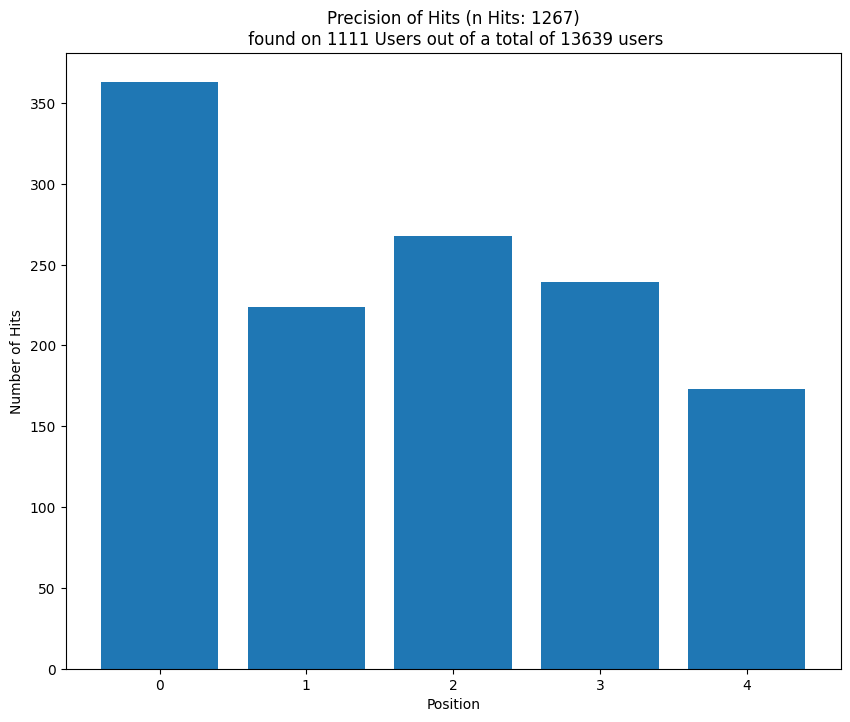

In [179]:
calculate_hits(testing_lsa, test_movies)

#### TFIDF

In [153]:
# runs 12 mins
testing_tfidf = tfidf_rec_user(df_movies_nlp, train_movies, cols)

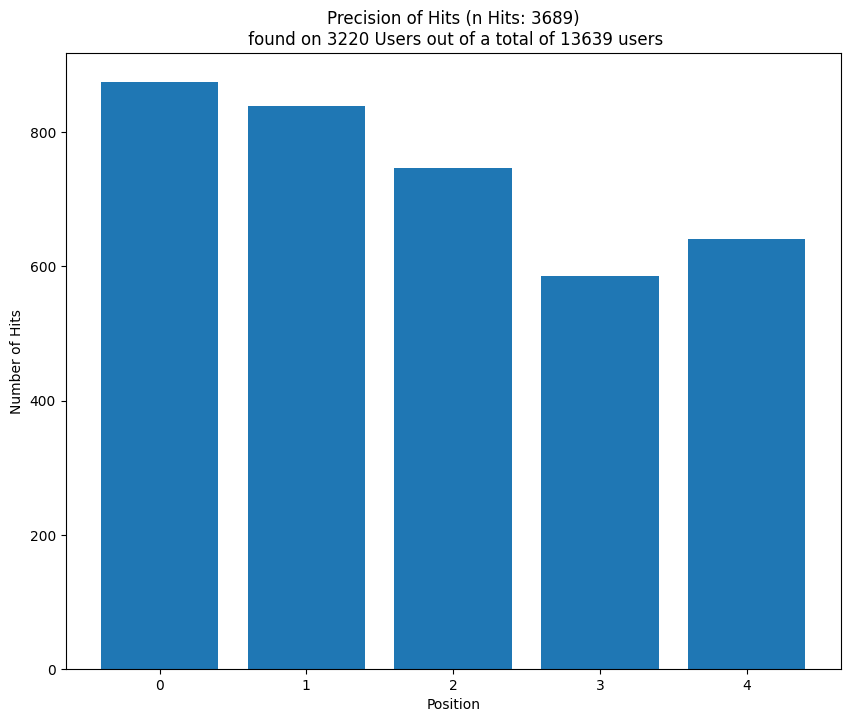

In [154]:
calculate_hits(testing_tfidf, test_movies)